In [1]:
# Cell 1: Installations
!pip install -U transformers==4.53.2
!pip install -U accelerate
!pip install -U bitsandbytes

# !pip install flash-attn==2.7.4.post1 \
#   --extra-index-url https://download.pytorch.org/whl/cu124 \
#   --no-build-isolation

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.9/40.9 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 39.6 MB/s eta 0:00:00
  Attempting uninstall: transformers
    Found existing installation: transformers 4.55.0
    Uninstalling transformers-4.55.0:
      Successfully uninstalled transformers-4.55.0
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.7/374.7 kB 18.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 84.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 83.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 59.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 41.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━

In [2]:
!pip install --no-deps bitsandbytes accelerate xformers==0.0.29.post3 peft trl triton unsloth_zoo
!pip install sentencepiece protobuf "datasets>=3.4.1,<4.0.0" "huggingface_hub>=0.34.0" hf_transfer
!pip install --no-deps unsloth

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.4/43.4 MB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.9/511.9 kB 33.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.4/176.4 kB 20.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 20.3 MB/s eta 0:00:00
  Attempting uninstall: datasets
    Found existing installation: datasets 4.0.0
    Uninstalling datasets-4.0.0:
      Successfully uninstalled datasets-4.0.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
unsloth-zoo 2025.8.3 requires cut_cross_entropy, which is not installed.
unsloth-zoo 2025.8.3 requires msgspec, which is not installed.
unsloth-zoo 2025.8.3 requires tyro, which is not installed.
trl 0.21.0 requires transformers>=4.55.0, but you have transformers 4.53.2 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.

In [3]:
import unsloth
from unsloth import FastModel
import torch
import torch.nn as nn
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
from peft import PeftModel
from huggingface_hub import hf_hub_download
import json
import re
import math

print("✅ All modules imported.")

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!
✅ All modules imported.


In [4]:
# ===================================================================
# 1. DEFINE CUSTOM CLASSIFIER (Required for Phi-4)
# ===================================================================
class GPTSequenceClassifier(nn.Module):
    def __init__(self, base_model, num_labels):
        super().__init__()
        self.base = base_model
        hidden_size = base_model.config.hidden_size
        self.classifier = nn.Linear(hidden_size, num_labels, bias=True)
        self.num_labels = num_labels

    def forward(self, input_ids=None, attention_mask=None, labels=None, **kwargs):
        outputs = self.base(input_ids=input_ids, attention_mask=attention_mask, output_hidden_states=True, **kwargs)
        last_hidden_state = outputs.hidden_states[-1]
        pooled_output = last_hidden_state[:, -1, :]
        logits = self.classifier(pooled_output)
        loss = None
        if labels is not None:
            loss = nn.functional.cross_entropy(logits.view(-1, self.num_labels), labels.view(-1))
        return {"loss": loss, "logits": logits} if loss is not None else {"logits": logits}

In [5]:
# ===================================================================
# 2. LOAD MODELS AND TOKENIZERS
# ===================================================================
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

# --- Model 1: Equation Extractor (Gemma-3 with Unsloth) ---
print("\nLoading Equation Extraction Model...")
extractor_adapter_repo = "arvindsuresh-math/gemma-3-1b-equation-line-extractor-aug-10"
base_gemma_model = "unsloth/gemma-3-1b-it-unsloth-bnb-4bit"

gemma_model, gemma_tokenizer = FastModel.from_pretrained(
    model_name=base_gemma_model,
    max_seq_length=350,
    dtype=None,
    load_in_4bit=True,
)
gemma_model = PeftModel.from_pretrained(gemma_model, extractor_adapter_repo)
print("✅ Equation Extraction Model loaded.")


# --- Model 2: Conceptual Error Classifier (Phi-4) ---
print("\nLoading Conceptual Error Classifier Model...")
classifier_adapter_repo = "arvindsuresh-math/phi-4-error-binary-classifier"
base_phi_model = "microsoft/Phi-4-mini-instruct"

DTYPE = torch.float16
quantization_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=DTYPE
    )
classifier_backbone_base = AutoModelForCausalLM.from_pretrained(
    base_phi_model,
    quantization_config=quantization_config,
    device_map="auto",
    trust_remote_code=True,
    )

classifier_tokenizer = AutoTokenizer.from_pretrained(
    base_phi_model,
    trust_remote_code=True
    )
classifier_tokenizer.padding_side = "left"
if classifier_tokenizer.pad_token is None:
    classifier_tokenizer.pad_token = classifier_tokenizer.eos_token

classifier_backbone_peft = PeftModel.from_pretrained(
    classifier_backbone_base,
    classifier_adapter_repo
    )
classifier_model = GPTSequenceClassifier(classifier_backbone_peft, num_labels=2)

# Download and load the custom classifier head's state dictionary
classifier_head_path = hf_hub_download(repo_id=classifier_adapter_repo, filename="classifier_head.pth")
classifier_model.classifier.load_state_dict(torch.load(classifier_head_path, map_location=device))

classifier_model.to(device)
classifier_model = classifier_model.to(torch.float16)

classifier_model.eval() # Set model to evaluation mode
print("✅ Conceptual Error Classifier Model loaded.")

Using device: cuda

Loading Equation Extraction Model...
==((====))==  Unsloth 2025.8.4: Fast Gemma3 patching. Transformers: 4.53.2.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 7.5. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.29.post3. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!
Unsloth: Using float16 precision for gemma3 won't work! Using float32.


<string>:36: UserWarning: You passed `quantization_config` or equivalent parameters to `from_pretrained` but the model you're loading already has a `quantization_config` attribute. The `quantization_config` from the model will be used.


model.safetensors:   0%|          | 0.00/1.00G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/233 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.model:   0%|          | 0.00/4.69M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/33.4M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/35.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/670 [00:00<?, ?B/s]

adapter_config.json: 0.00B [00:00, ?B/s]

adapter_model.safetensors:   0%|          | 0.00/52.2M [00:00<?, ?B/s]

✅ Equation Extraction Model loaded.

Loading Conceptual Error Classifier Model...


config.json: 0.00B [00:00, ?B/s]

configuration_phi3.py: 0.00B [00:00, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/microsoft/Phi-4-mini-instruct:
- configuration_phi3.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


modeling_phi3.py: 0.00B [00:00, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/microsoft/Phi-4-mini-instruct:
- modeling_phi3.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


model.safetensors.index.json: 0.00B [00:00, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.90G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/2.77G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/168 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json:   0%|          | 0.00/15.5M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/249 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/587 [00:00<?, ?B/s]

adapter_config.json:   0%|          | 0.00/932 [00:00<?, ?B/s]

adapter_model.safetensors:   0%|          | 0.00/92.3M [00:00<?, ?B/s]

classifier_head.pth:   0%|          | 0.00/26.1k [00:00<?, ?B/s]

✅ Conceptual Error Classifier Model loaded.


In [6]:
# ===================================================================
# 3. PROMPTS
# ===================================================================

EXTRACTOR_SYSTEM_PROMPT = \
"""[ROLE]
You are an expert at parsing mathematical solutions.

[TASK]
You are given a single line from a mathematical solution. Your task is to extract the calculation from this line.

**This is a literal transcription task. Follow these rules with extreme precision:**
- **RULE 1: Transcribe EXACTLY.** Do not correct mathematical errors. If a line implies `2+2=5`, your output for that line must be `2+2=5`.
- **RULE 2: Isolate the Equation.** Your output must contain ONLY the equation, with no surrounding text, units, or currency symbols. Always use `*` for multiplication.

[RESPONSE FORMAT]
Your response must ONLY contain the extracted equation, wrapped in <eq> and </eq> tags.
If the line contains no calculation, respond with empty tags: <eq></eq>.
"""

CLASSIFIER_SYSTEM_PROMPT = \
"""You are a mathematics tutor.
You will be given a math word problem and a solution written by a student.
Carefully analyze the problem and solution LINE-BY-LINE and determine whether there are any errors in the solution."""

In [7]:
# ===================================================================
# 3. HELPERS
# ===================================================================

# --- Helper Functions ---
def extract_equation_from_response(response: str) -> str | None:
    """Extracts content from between <eq> and </eq> tags."""
    match = re.search(r'<eq>(.*?)</eq>', response, re.DOTALL)
    return match.group(1) if match else None

def sanitize_equation_string(expression: str) -> str:
    """
    Enhanced version with your requested simplified parenthesis logic.
    """
    if not isinstance(expression, str):
        return ""

    # Your requested parenthesis logic:
    if expression.count('(') > expression.count(')') and expression.startswith('('):
        expression = expression[1:]
    elif expression.count(')') > expression.count('(') and expression.endswith(')'):
        expression = expression[:-1]

    sanitized = expression.replace(' ', '')
    sanitized = sanitized.replace('x', '*').replace('×', '*')
    sanitized = re.sub(r'/([a-zA-Z]+)', '', sanitized)
    sanitized = re.sub(r'[^\d.()+\-*/=]', '', sanitized)
    return sanitized

def evaluate_equations(eq_dict: dict, sol_dict: dict):
    """
    Evaluates extracted equations and returns a more detailed dictionary for
    building clearer explanations.
    """
    for key, eq_str in eq_dict.items():
        if not eq_str or "=" not in eq_str:
            continue
        try:
            sanitized_eq = sanitize_equation_string(eq_str)

            if not sanitized_eq or "=" not in sanitized_eq:
                continue

            lhs, rhs_str = sanitized_eq.split('=', 1)

            if not lhs or not rhs_str:
                continue

            lhs_val = eval(lhs, {"__builtins__": None}, {})
            rhs_val = eval(rhs_str, {"__builtins__": None}, {})

            if not math.isclose(lhs_val, rhs_val, rel_tol=1e-2):
                correct_rhs_val = round(lhs_val, 4)
                correct_rhs_str = f"{correct_rhs_val:.4f}".rstrip('0').rstrip('.')

                # Return a more detailed dictionary for better explanations
                return {
                    "error": True,
                    "line_key": key,
                    "line_text": sol_dict.get(key, "N/A"),
                    "original_flawed_calc": eq_str, # The raw model output
                    "sanitized_lhs": lhs,           # The clean left side
                    "original_rhs": rhs_str,        # The clean right side
                    "correct_rhs": correct_rhs_str, # The correct right side
                }
        except Exception:
            continue

    return {"error": False}

In [ ]:
# ===================================================================
# 4. PIPELINE COMPONENTS
# ===================================================================

def run_conceptual_check(question: str, solution: str, model, tokenizer) -> dict:
    """
    STAGE 1: Runs the Phi-4 classifier with memory optimizations.
    """
    input_text = f"{CLASSIFIER_SYSTEM_PROMPT}\n\n### Problem:\n{question}\n\n### Answer:\n{solution}"
    inputs = tokenizer(
        input_text,
        return_tensors="pt",
        truncation=True,
        max_length=512).to(device)

    # Use inference_mode and disable cache for better performance and memory management
    with torch.inference_mode():
        outputs = model(**inputs, use_cache=False)

        # Explicitly cast logits to float32 for stable downstream processing
        logits = outputs["logits"].to(torch.float32)
        probs = torch.softmax(logits, dim=-1).squeeze().tolist()

    is_flawed_prob = probs[1]
    prediction = "flawed" if is_flawed_prob > 0.5 else "correct"

    return {
        "prediction": prediction,
        "probabilities": {"correct": probs[0], "flawed": probs[1]}
    }

def run_computational_check(solution: str, model, tokenizer, batch_size: int = 32) -> dict:
    """
    STAGE 2: Splits a solution into lines, performs a batched computational check,
    and returns detailed results including all extracted equations.
    """
    lines = [line.strip() for line in solution.strip().split('\n') if line.strip() and "FINAL ANSWER:" not in line.upper()]
    if not lines:
        # Return the new, more detailed structure even for empty cases
        return {"error_details": None, "raw_equations": [], "cleaned_equations": []}

    prompts = []
    for line in lines:
        messages = [{"role": "user", "content": f"{EXTRACTOR_SYSTEM_PROMPT}\n\n### Solution Line:\n{line}"}]
        prompts.append(tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True))

    tokenizer.padding_side = "left"
    inputs = tokenizer(prompts, return_tensors="pt", padding=True).to(device)
    tokenizer.padding_side = "left"
    outputs = model.generate(**inputs, max_new_tokens=64, use_cache=True, pad_token_id=tokenizer.pad_token_id)
    tokenizer.padding_side = "left"
    decoded_outputs = tokenizer.batch_decode(outputs[:, inputs.input_ids.shape[1]:], skip_special_tokens=True)

    # --- NEW: Store all equations and any error found ---
    error_payload = None
    raw_equations = []
    cleaned_equations = []

    for i, raw_output in enumerate(decoded_outputs):
        raw_eq = extract_equation_from_response(raw_output)
        raw_equations.append(raw_eq if raw_eq is not None else "") # Store raw equation or empty string

        cleaned_eq = sanitize_equation_string(raw_eq)
        cleaned_equations.append(cleaned_eq) # Store cleaned equation

        # Only check for errors if an error hasn't already been found
        if not error_payload and cleaned_eq and "=" in cleaned_eq:
            try:
                lhs, rhs_str = cleaned_eq.split('=', 1)
                lhs_val = eval(lhs, {"__builtins__": None}, {})
                if not math.isclose(lhs_val, float(rhs_str), rel_tol=1e-2):
                    # Store the first error found and stop checking
                    error_payload = {
                        "line_text": lines[i],
                        "correct_calc": f"{lhs} = {round(lhs_val, 4)}"
                    }
            except Exception:
                continue

    return {
        "error_details": error_payload,
        "raw_equations": raw_equations,
        "cleaned_equations": cleaned_equations
    }


def analyze_solution(question: str, solution: str) -> dict:
    """
    Main orchestrator that runs the full pipeline and returns a detailed dictionary.
    """
    # STAGE 1: Conceptual Check (Fast)
    conceptual_result = run_conceptual_check(question, solution, classifier_model, classifier_tokenizer)

    # STAGE 2: Computational Check (Slower, Batched)
    computational_result = run_computational_check(solution, gemma_model, gemma_tokenizer)
    comp_error_details = computational_result["error_details"]

    # FINAL VERDICT LOGIC
    if comp_error_details:
        classification = "computational_error"
        explanation = (
            f"A calculation error was found.\n"
            f"On the line: \"{comp_error_details['line_text']}\"\n"
            f"The correct calculation should be: {comp_error_details['correct_calc']}"
        )
    else:
        # If calculations are fine, the final verdict is the conceptual one.
        if conceptual_result['prediction'] == 'correct':
            classification = 'correct'
            explanation = "All calculations are correct and the overall logic appears to be sound."
        else: # Corresponds to 'flawed'
            classification = 'conceptual_error'
            explanation = "All calculations are correct, but there appears to be a conceptual error in the logic or setup of the solution."

    # Return a comprehensive dictionary with all required information
    return {
        "classification": classification,
        "explanation": explanation,
        "raw_equations": computational_result["raw_equations"],
        "cleaned_equations": computational_result["cleaned_equations"]
    }

In [44]:
import pandas as pd
from tqdm.notebook import tqdm
import time
import numpy as np

def test_pipeline(df: pd.DataFrame) -> pd.DataFrame:
    """
    Runs the full analysis pipeline sample-by-sample on a test DataFrame.

    Args:
        df: A DataFrame with at least the columns 'question', 'answer',
            and 'error_type'. An optional 'index' column can be used.

    Returns:
        A new DataFrame with detailed results and performance metrics.
    """
    print(f"--- Starting Final Evaluation on {len(df)} Samples ---")
    results_data = []

    # Determine if we should use an existing index or the DataFrame's index
    use_original_index = 'index' in df.columns

    for idx, row in tqdm(df.iterrows(), total=len(df), desc="Processing Samples"):
        question = row['question']
        answer = row['answer']
        true_error_type = row['error_type']

        start_time = time.monotonic()
        pipeline_result = analyze_solution(question, answer)
        end_time = time.monotonic()

        latency = np.round(end_time - start_time,2)
        pred_error_type = pipeline_result['classification']
        is_correct = (true_error_type == pred_error_type)

        print(f"Sample {idx:<5} | Latency {latency:<5} | is_correct: {is_correct}")

        results_data.append({
            'index': row['index'] if use_original_index else idx,
            'question': question,
            'answer': answer,
            'true_error_type': true_error_type,
            'pred_error_type': pred_error_type,
            'raw_equations': pipeline_result['raw_equations'],
            'cleaned_equations': pipeline_result['cleaned_equations'],
            'is_correct': is_correct,
            'latency': latency
        })

    print("\n--- ✅ Final Evaluation Complete ---")
    return pd.DataFrame(results_data)

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

def compute_final_metrics(results_df: pd.DataFrame):
    """
    Computes and displays key performance metrics and visualizations.

    Args:
        results_df: The DataFrame generated by run_final_evaluation.
    """
    y_true = results_df['true_error_type']
    y_pred = results_df['pred_error_type']

    # Define the canonical order for labels in reports and plots
    labels = sorted(list(set(y_true)))

    # --- 1. Classification Report ---
    print("="*80)
    print("Classification Report")
    print("="*80)
    report = classification_report(y_true, y_pred, labels=labels)
    print(report)

    # --- 2. Confusion Matrices ---
    print("\n" + "="*80)
    print("Confusion Matrices")
    print("="*80)

    # Create two subplots for the matrices
    fig, axes = plt.subplots(1, 2, figsize=(20, 8))
    fig.suptitle('Pipeline Performance Analysis', fontsize=20)

    # Plot Raw Confusion Matrix
    cm_raw = confusion_matrix(y_true, y_pred, labels=labels)
    sns.heatmap(cm_raw, annot=True, fmt='d', cmap='Blues', ax=axes[0],
                xticklabels=labels, yticklabels=labels, annot_kws={"size": 14})
    axes[0].set_title('Confusion Matrix (Raw Counts)', fontsize=16)
    axes[0].set_xlabel('Predicted Label', fontsize=12)
    axes[0].set_ylabel('True Label', fontsize=12)

    # Plot Normalized Confusion Matrix (by True Label / Recall)
    cm_norm = cm_raw.astype('float') / cm_raw.sum(axis=1)[:, np.newaxis]
    sns.heatmap(cm_norm, annot=True, fmt='.2%', cmap='Blues', ax=axes[1],
                xticklabels=labels, yticklabels=labels, annot_kws={"size": 14})
    axes[1].set_title('Normalized Confusion Matrix (% of True Label)', fontsize=16)
    axes[1].set_xlabel('Predicted Label', fontsize=12)
    axes[1].set_ylabel('True Label', fontsize=12)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

In [45]:
final_test_df = pd.read_csv("/content/final-test-with-wrong-answers.csv")
sft_test_df = pd.read_csv("/content/error_detection_dataset.csv")

final_test_data = []
for idx, row in final_test_df.iterrows():
    # Append the correct version of the solution
    final_test_data.append({
        "index": idx, # use test set index
        "question": row["question"],
        "answer": row["correct_answer"],
        "error_type": "correct"
    })
    # Append the flawed version of the solution
    error = "conceptual_error" if row["error_type"] == "concep" else "computational_error"
    final_test_data.append({
        "question": row["question"],
        "answer": row["wrong_answer"],
        "error_type": error
    })

sft_test_data = []
sft_test_df = sft_test_df[sft_test_df["split"] == "test"]
for _, row in sft_test_df.iterrows():
    if row["error_type"] == "correct":
        answer = row["correct_answer"]
    else:
        answer = row["wrong_answer"]
    sft_test_data.append({
        "index": row["index"], # use gsm8k index
        "question": row["question"],
        "answer": answer,
        "error_type": row["error_type"]
    })

final_test_df = pd.DataFrame(final_test_data)
sft_test_df = pd.DataFrame(sft_test_data)

In [42]:
pd.set_option('display.max_colwidth', None)
pd.set_option('display.width', 0)

In [46]:
final_test_results = test_pipeline(final_test_df)

--- Starting Final Evaluation on 302 Samples ---


Processing Samples:   0%|          | 0/302 [00:00<?, ?it/s]

Sample 0     | Latency 3.58  | is_correct: True
Sample 1     | Latency 3.06  | is_correct: False
Sample 2     | Latency 3.28  | is_correct: True
Sample 3     | Latency 3.27  | is_correct: True
Sample 4     | Latency 4.43  | is_correct: True
Sample 5     | Latency 4.62  | is_correct: True
Sample 6     | Latency 2.92  | is_correct: True
Sample 7     | Latency 2.87  | is_correct: True
Sample 8     | Latency 3.31  | is_correct: True
Sample 9     | Latency 3.36  | is_correct: True
Sample 10    | Latency 3.09  | is_correct: True
Sample 11    | Latency 2.7   | is_correct: True
Sample 12    | Latency 2.36  | is_correct: True
Sample 13    | Latency 2.43  | is_correct: True
Sample 14    | Latency 2.84  | is_correct: True
Sample 15    | Latency 2.55  | is_correct: True
Sample 16    | Latency 3.09  | is_correct: True
Sample 17    | Latency 3.16  | is_correct: True
Sample 18    | Latency 2.73  | is_correct: True
Sample 19    | Latency 2.44  | is_correct: True
Sample 20    | Latency 3.67  | is_corre

<string>:1: SyntaxWarning: 'int' object is not callable; perhaps you missed a comma?


Sample 40    | Latency 4.53  | is_correct: True
Sample 41    | Latency 4.08  | is_correct: True
Sample 42    | Latency 3.1   | is_correct: True
Sample 43    | Latency 3.12  | is_correct: True
Sample 44    | Latency 3.26  | is_correct: True
Sample 45    | Latency 3.22  | is_correct: True
Sample 46    | Latency 3.37  | is_correct: True
Sample 47    | Latency 3.8   | is_correct: True
Sample 48    | Latency 2.75  | is_correct: True
Sample 49    | Latency 2.73  | is_correct: True
Sample 50    | Latency 3.07  | is_correct: True
Sample 51    | Latency 3.09  | is_correct: True
Sample 52    | Latency 2.89  | is_correct: True
Sample 53    | Latency 2.93  | is_correct: True
Sample 54    | Latency 2.61  | is_correct: True
Sample 55    | Latency 2.55  | is_correct: True
Sample 56    | Latency 3.6   | is_correct: True
Sample 57    | Latency 3.66  | is_correct: True
Sample 58    | Latency 3.3   | is_correct: True
Sample 59    | Latency 3.34  | is_correct: False
Sample 60    | Latency 2.93  | is_corre

<string>:1: SyntaxWarning: 'int' object is not callable; perhaps you missed a comma?


Sample 293   | Latency 5.0   | is_correct: True
Sample 294   | Latency 5.54  | is_correct: True
Sample 295   | Latency 5.5   | is_correct: True
Sample 296   | Latency 7.98  | is_correct: False
Sample 297   | Latency 6.41  | is_correct: False
Sample 298   | Latency 5.18  | is_correct: True
Sample 299   | Latency 5.08  | is_correct: True
Sample 300   | Latency 4.38  | is_correct: True
Sample 301   | Latency 4.4   | is_correct: True

--- ✅ Final Evaluation Complete ---


In [47]:
sft_test_results = test_pipeline(sft_test_df)

--- Starting Final Evaluation on 1214 Samples ---


Processing Samples:   0%|          | 0/1214 [00:00<?, ?it/s]

Sample 0     | Latency 3.26  | is_correct: True
Sample 1     | Latency 2.91  | is_correct: True
Sample 2     | Latency 4.27  | is_correct: True
Sample 3     | Latency 3.19  | is_correct: True
Sample 4     | Latency 4.91  | is_correct: True
Sample 5     | Latency 3.16  | is_correct: True
Sample 6     | Latency 3.29  | is_correct: False
Sample 7     | Latency 2.33  | is_correct: True
Sample 8     | Latency 3.23  | is_correct: True
Sample 9     | Latency 3.1   | is_correct: True
Sample 10    | Latency 4.18  | is_correct: True
Sample 11    | Latency 3.31  | is_correct: True
Sample 12    | Latency 2.51  | is_correct: True
Sample 13    | Latency 2.93  | is_correct: True
Sample 14    | Latency 2.96  | is_correct: True
Sample 15    | Latency 3.23  | is_correct: False
Sample 16    | Latency 3.09  | is_correct: True
Sample 17    | Latency 2.67  | is_correct: True
Sample 18    | Latency 3.48  | is_correct: False
Sample 19    | Latency 2.73  | is_correct: True
Sample 20    | Latency 3.58  | is_cor

<string>:1: SyntaxWarning: 'int' object is not callable; perhaps you missed a comma?


Sample 121   | Latency 2.94  | is_correct: True
Sample 122   | Latency 3.15  | is_correct: True
Sample 123   | Latency 2.97  | is_correct: True
Sample 124   | Latency 3.9   | is_correct: True
Sample 125   | Latency 3.44  | is_correct: False
Sample 126   | Latency 2.66  | is_correct: True
Sample 127   | Latency 2.85  | is_correct: True
Sample 128   | Latency 3.75  | is_correct: True
Sample 129   | Latency 3.34  | is_correct: True
Sample 130   | Latency 2.79  | is_correct: True
Sample 131   | Latency 4.44  | is_correct: True
Sample 132   | Latency 2.79  | is_correct: True
Sample 133   | Latency 3.22  | is_correct: True
Sample 134   | Latency 3.23  | is_correct: True
Sample 135   | Latency 2.58  | is_correct: True
Sample 136   | Latency 4.29  | is_correct: True
Sample 137   | Latency 3.37  | is_correct: False
Sample 138   | Latency 2.57  | is_correct: True
Sample 139   | Latency 3.09  | is_correct: True
Sample 140   | Latency 3.09  | is_correct: True
Sample 141   | Latency 3.5   | is_corr

<string>:1: SyntaxWarning: 'int' object is not callable; perhaps you missed a comma?


Sample 178   | Latency 3.06  | is_correct: False
Sample 179   | Latency 3.06  | is_correct: True
Sample 180   | Latency 3.55  | is_correct: True
Sample 181   | Latency 4.19  | is_correct: True
Sample 182   | Latency 4.0   | is_correct: True
Sample 183   | Latency 2.78  | is_correct: True
Sample 184   | Latency 3.54  | is_correct: True
Sample 185   | Latency 3.07  | is_correct: True
Sample 186   | Latency 3.15  | is_correct: True
Sample 187   | Latency 2.78  | is_correct: False
Sample 188   | Latency 3.53  | is_correct: True
Sample 189   | Latency 3.26  | is_correct: False
Sample 190   | Latency 2.76  | is_correct: False
Sample 191   | Latency 3.79  | is_correct: False
Sample 192   | Latency 2.64  | is_correct: True
Sample 193   | Latency 3.29  | is_correct: False
Sample 194   | Latency 2.84  | is_correct: False
Sample 195   | Latency 2.29  | is_correct: True
Sample 196   | Latency 2.5   | is_correct: True
Sample 197   | Latency 2.97  | is_correct: True
Sample 198   | Latency 3.49  | is

<string>:1: SyntaxWarning: 'int' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'int' object is not callable; perhaps you missed a comma?


Sample 208   | Latency 4.24  | is_correct: True
Sample 209   | Latency 4.65  | is_correct: True
Sample 210   | Latency 3.87  | is_correct: False
Sample 211   | Latency 3.17  | is_correct: False
Sample 212   | Latency 3.22  | is_correct: False
Sample 213   | Latency 2.97  | is_correct: False
Sample 214   | Latency 3.03  | is_correct: True
Sample 215   | Latency 4.34  | is_correct: False
Sample 216   | Latency 4.75  | is_correct: False
Sample 217   | Latency 2.79  | is_correct: True
Sample 218   | Latency 4.65  | is_correct: True
Sample 219   | Latency 2.98  | is_correct: True
Sample 220   | Latency 3.18  | is_correct: True
Sample 221   | Latency 3.06  | is_correct: True
Sample 222   | Latency 3.22  | is_correct: True
Sample 223   | Latency 2.63  | is_correct: False
Sample 224   | Latency 2.86  | is_correct: True
Sample 225   | Latency 2.96  | is_correct: True
Sample 226   | Latency 2.62  | is_correct: True
Sample 227   | Latency 3.18  | is_correct: False
Sample 228   | Latency 2.48  | i

<string>:1: SyntaxWarning: 'int' object is not callable; perhaps you missed a comma?


Sample 708   | Latency 3.11  | is_correct: True
Sample 709   | Latency 3.89  | is_correct: True
Sample 710   | Latency 2.73  | is_correct: True
Sample 711   | Latency 5.41  | is_correct: True
Sample 712   | Latency 3.63  | is_correct: True
Sample 713   | Latency 3.31  | is_correct: False
Sample 714   | Latency 2.38  | is_correct: True
Sample 715   | Latency 3.22  | is_correct: True
Sample 716   | Latency 2.9   | is_correct: True
Sample 717   | Latency 3.24  | is_correct: False
Sample 718   | Latency 3.57  | is_correct: True
Sample 719   | Latency 3.58  | is_correct: True
Sample 720   | Latency 2.74  | is_correct: True
Sample 721   | Latency 2.9   | is_correct: False
Sample 722   | Latency 3.41  | is_correct: True
Sample 723   | Latency 2.59  | is_correct: True
Sample 724   | Latency 2.76  | is_correct: True
Sample 725   | Latency 4.11  | is_correct: True
Sample 726   | Latency 2.22  | is_correct: True
Sample 727   | Latency 3.07  | is_correct: True
Sample 728   | Latency 2.73  | is_cor

<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?


Sample 887   | Latency 4.84  | is_correct: True
Sample 888   | Latency 3.26  | is_correct: True
Sample 889   | Latency 3.69  | is_correct: True
Sample 890   | Latency 4.17  | is_correct: True
Sample 891   | Latency 2.93  | is_correct: True
Sample 892   | Latency 2.94  | is_correct: True
Sample 893   | Latency 3.27  | is_correct: True
Sample 894   | Latency 3.02  | is_correct: True
Sample 895   | Latency 4.63  | is_correct: True
Sample 896   | Latency 3.46  | is_correct: True
Sample 897   | Latency 3.89  | is_correct: True
Sample 898   | Latency 3.36  | is_correct: False
Sample 899   | Latency 4.23  | is_correct: True
Sample 900   | Latency 4.32  | is_correct: True
Sample 901   | Latency 2.86  | is_correct: True
Sample 902   | Latency 3.3   | is_correct: False
Sample 903   | Latency 2.99  | is_correct: True
Sample 904   | Latency 4.33  | is_correct: True
Sample 905   | Latency 3.61  | is_correct: True
Sample 906   | Latency 4.35  | is_correct: True
Sample 907   | Latency 3.7   | is_corr

<string>:1: SyntaxWarning: 'int' object is not callable; perhaps you missed a comma?


Sample 912   | Latency 4.02  | is_correct: True
Sample 913   | Latency 4.23  | is_correct: True
Sample 914   | Latency 3.26  | is_correct: True
Sample 915   | Latency 3.24  | is_correct: True
Sample 916   | Latency 3.33  | is_correct: True
Sample 917   | Latency 2.56  | is_correct: False
Sample 918   | Latency 2.37  | is_correct: False
Sample 919   | Latency 3.11  | is_correct: True
Sample 920   | Latency 3.86  | is_correct: True
Sample 921   | Latency 5.8   | is_correct: False
Sample 922   | Latency 3.73  | is_correct: True
Sample 923   | Latency 3.48  | is_correct: True
Sample 924   | Latency 3.04  | is_correct: True
Sample 925   | Latency 4.32  | is_correct: True
Sample 926   | Latency 3.81  | is_correct: True
Sample 927   | Latency 3.29  | is_correct: False
Sample 928   | Latency 3.95  | is_correct: False
Sample 929   | Latency 3.32  | is_correct: True
Sample 930   | Latency 3.4   | is_correct: True
Sample 931   | Latency 4.08  | is_correct: True
Sample 932   | Latency 4.52  | is_c

<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?


Sample 990   | Latency 5.36  | is_correct: True
Sample 991   | Latency 3.88  | is_correct: True
Sample 992   | Latency 2.8   | is_correct: False
Sample 993   | Latency 4.32  | is_correct: True
Sample 994   | Latency 5.1   | is_correct: True
Sample 995   | Latency 4.1   | is_correct: True
Sample 996   | Latency 4.19  | is_correct: True
Sample 997   | Latency 3.1   | is_correct: True
Sample 998   | Latency 3.91  | is_correct: True
Sample 999   | Latency 2.94  | is_correct: True
Sample 1000  | Latency 3.45  | is_correct: False
Sample 1001  | Latency 3.29  | is_correct: True
Sample 1002  | Latency 2.79  | is_correct: True
Sample 1003  | Latency 3.63  | is_correct: True
Sample 1004  | Latency 3.46  | is_correct: False
Sample 1005  | Latency 4.37  | is_correct: True
Sample 1006  | Latency 4.93  | is_correct: False
Sample 1007  | Latency 4.54  | is_correct: False
Sample 1008  | Latency 4.19  | is_correct: True
Sample 1009  | Latency 4.56  | is_correct: True
Sample 1010  | Latency 3.84  | is_c

<string>:1: SyntaxWarning: 'int' object is not callable; perhaps you missed a comma?


Sample 1158  | Latency 3.57  | is_correct: False
Sample 1159  | Latency 3.92  | is_correct: True
Sample 1160  | Latency 2.77  | is_correct: False
Sample 1161  | Latency 3.39  | is_correct: True
Sample 1162  | Latency 3.11  | is_correct: True
Sample 1163  | Latency 3.23  | is_correct: True
Sample 1164  | Latency 2.94  | is_correct: True
Sample 1165  | Latency 3.0   | is_correct: True
Sample 1166  | Latency 2.63  | is_correct: True
Sample 1167  | Latency 3.04  | is_correct: True
Sample 1168  | Latency 2.5   | is_correct: True
Sample 1169  | Latency 3.15  | is_correct: True
Sample 1170  | Latency 2.64  | is_correct: True
Sample 1171  | Latency 3.51  | is_correct: True
Sample 1172  | Latency 2.97  | is_correct: True
Sample 1173  | Latency 3.56  | is_correct: True
Sample 1174  | Latency 3.91  | is_correct: True
Sample 1175  | Latency 3.71  | is_correct: True
Sample 1176  | Latency 3.27  | is_correct: True
Sample 1177  | Latency 3.07  | is_correct: True
Sample 1178  | Latency 3.17  | is_corr

Classification Report
                     precision    recall  f1-score   support

computational_error       0.64      0.93      0.76        75
   conceptual_error       0.73      0.64      0.69        76
            correct       0.93      0.77      0.84       151

           accuracy                           0.78       302
          macro avg       0.77      0.78      0.76       302
       weighted avg       0.81      0.78      0.78       302


Confusion Matrices


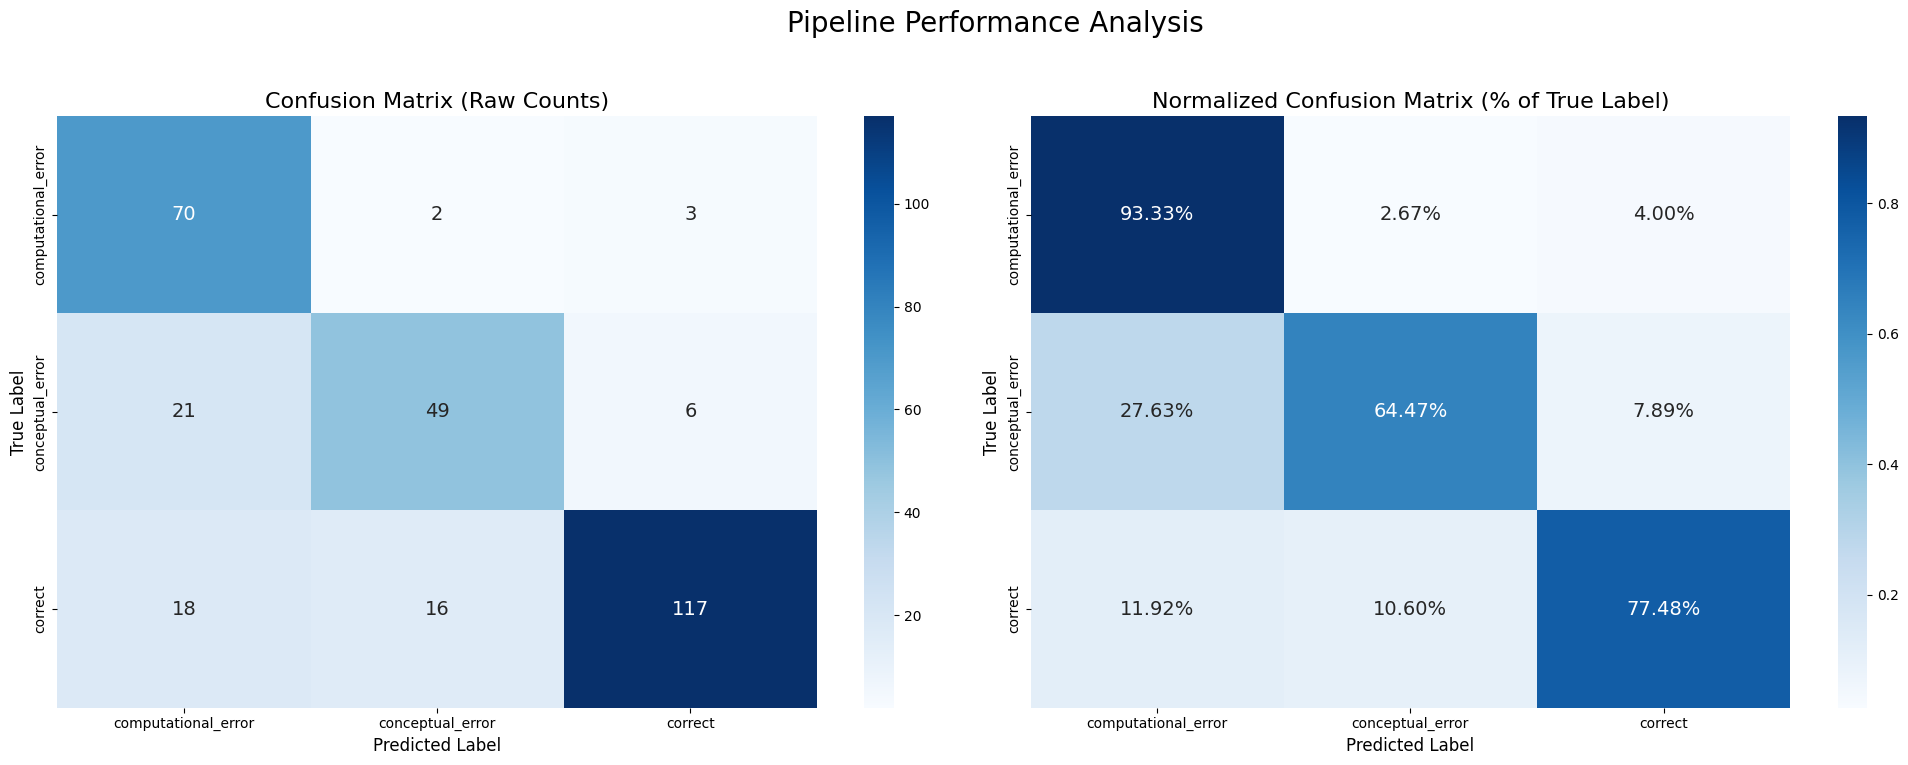

In [48]:
compute_final_metrics(final_test_results)

Classification Report
                     precision    recall  f1-score   support

computational_error       0.75      0.93      0.83       400
   conceptual_error       0.85      0.78      0.81       414
            correct       0.90      0.76      0.82       400

           accuracy                           0.82      1214
          macro avg       0.83      0.82      0.82      1214
       weighted avg       0.83      0.82      0.82      1214


Confusion Matrices


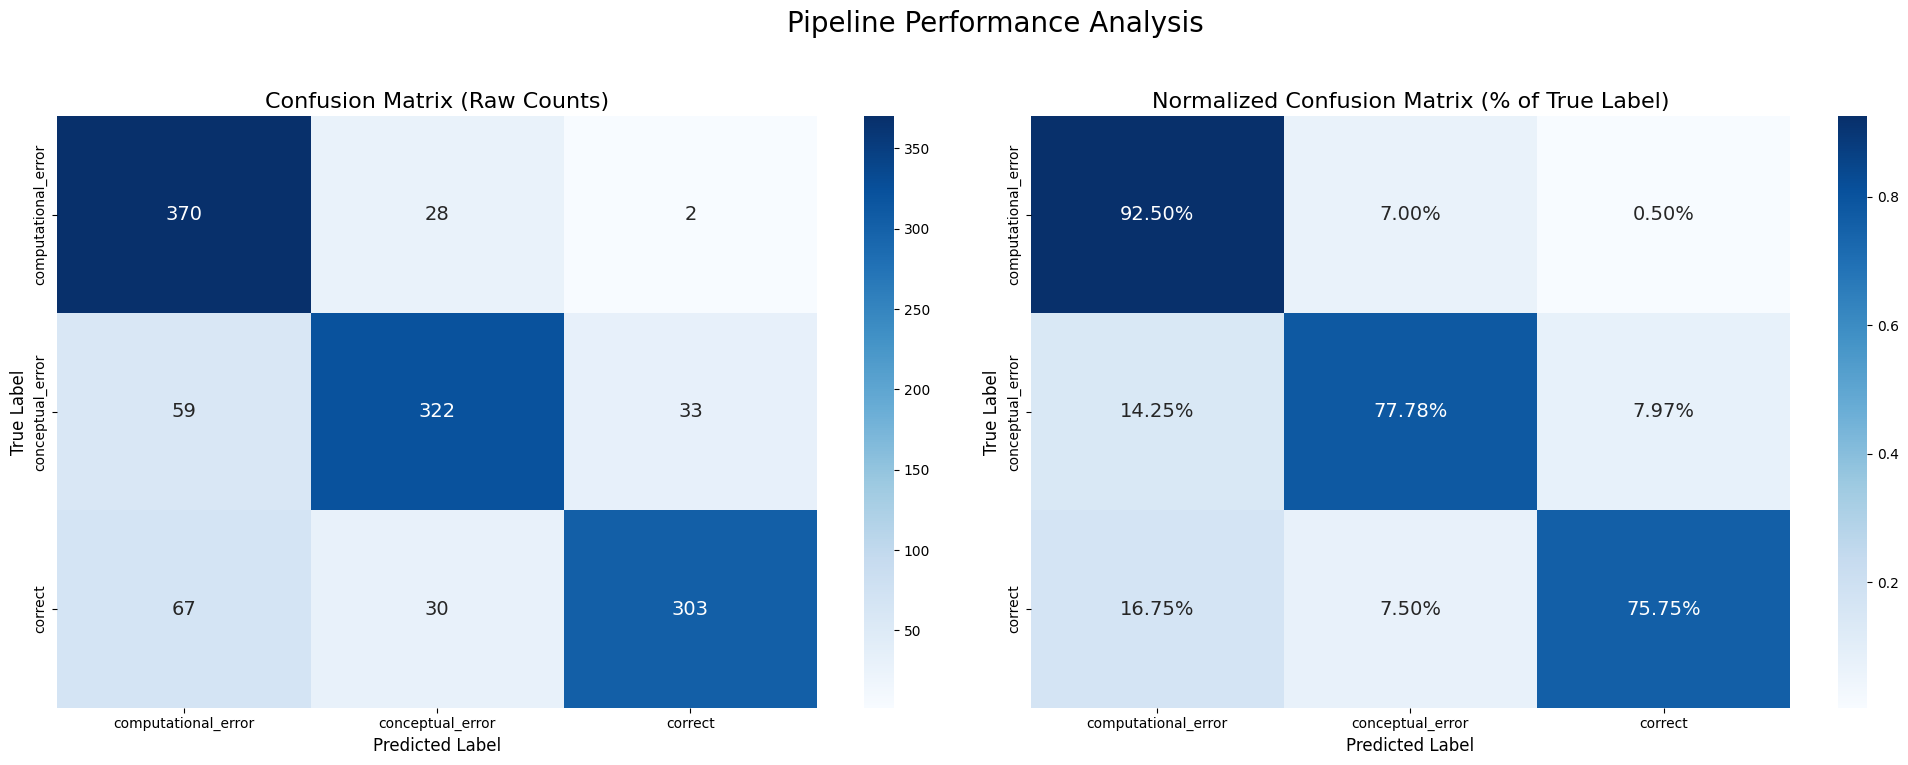

In [49]:
compute_final_metrics(sft_test_results)

In [50]:
final_test_results.to_csv("/content/final-test-results.csv")
sft_test_results.to_csv("/content/sft-test-results.csv")